In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_openml
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score
from somperf.metrics import *
from somperf.utils.topology import rectangular_topology_dist

import optuna
import numpy as np

d:\Kuliah\JST\Neural-Network-Final-Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##Data Analysis

In [2]:
df = pd.read_excel('dataset.xlsx', sheet_name='Sheet1') 
data = df.iloc[:,:-1].values

###Preprocessing

In [3]:
#Standarization
scaler = StandardScaler()

df_scaled = scaler.fit_transform(df.copy())
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

df_scaled.head(3)

,meanR,meanG,meanB,stdR,stdG,stdB,skewR,skewG,skewB,kurR,kurG,kurB,entR,entG,entB,Class
0,-0.665102,0.008693,-0.644699,-0.957046,-0.074790,-0.358296,-0.280260,-0.336533,0.694148,-0.275050,-0.357389,0.413462,0.260530,0.270445,-1.030791,-1.344481
1,-0.731039,-0.226412,-0.811958,-0.894219,-0.183617,-0.720664,0.071609,0.002909,0.695626,0.022708,-0.088418,0.532731,-0.107272,-0.118157,-1.012572,-1.344481
2,-0.178144,-0.392545,-0.305512,-0.087327,-0.407671,-0.370002,0.016748,0.039301,0.182180,-0.090864,-0.068511,0.161766,-0.205810,-0.210945,0.042868,-1.344481


In [4]:
#Split Dataset
X = df_scaled.drop(columns=['Class'])
y = df_scaled['Class']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

###Dimension Reduction

In [5]:
def plot_dimension(data):
    plt.figure(figsize=(16, 8))
    scatter = plt.scatter(data[:, 0], data[:, 1], c=y_train, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, ticks=range(1, 7), label='Class')
    plt.title("Visualization of Classes")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.grid(True)
    plt.show()

In [6]:
#Dimension Reduction TSNE
tsne = TSNE(n_components=2, perplexity=21, n_iter=1269, random_state=42, learning_rate = 18.896459784706366)
X_tsne = tsne.fit_transform(X_train)

d:\Kuliah\JST\Neural-Network-Final-Project\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


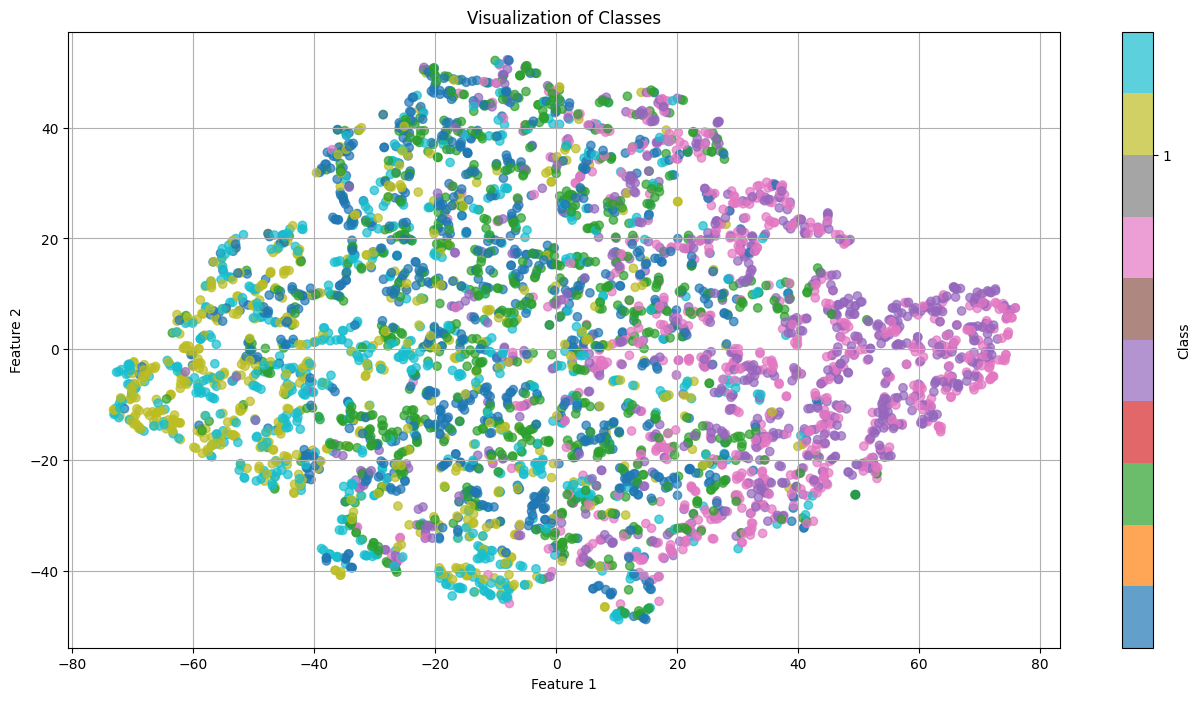

In [7]:
plot_dimension(X_tsne)

###Building Model

In [8]:
class SOMlinier:
    def __init__(self, m, fitur, R, alpha, tau):
        self.m = m 
        self.fitur = fitur 
        self.w = np.random.rand(m, fitur) 
        self.R0 = R 
        self.alpha0 = alpha
        self.tau = tau
    
    def hitung_bmu(self, x):
        # Menghitung jarak antara x dan setiap neuron
        D = np.linalg.norm(self.w - x, axis=1)
        # Kembalikan indeks dari BMU (neuron dengan jarak terdekat)
        return np.argmin(D)
    
    def hitung_second_bmu(self, x):
        # Menghitung jarak antara x dan setiap neuron
        D = np.linalg.norm(self.w - x, axis=1)
        # Urutkan indeks jarak, ambil indeks kedua terdekat
        return np.argsort(D)[1]
    
    def update_bobot(self, x, j, R, alpha):
        for i in range(self.m):
            jarak = abs(i - j)
            if jarak <= R:
                influence = np.exp(-jarak**2 / (2 * (R**2)))
                self.w[i] += alpha * influence * (x - self.w[i])
    
    def kurangi_radius(self, iterasi):
        return self.R0 * np.exp(-iterasi / self.tau)

    def kurangi_learning_rate(self, iterasi):
        return self.alpha0 * np.exp(-iterasi / self.tau)

    def train(self, data, n_iterasi):
        for t in range(n_iterasi):
            x = data[np.random.randint(0, len(data))]
            j = self.hitung_bmu(x)
            R = self.kurangi_radius(t)
            alpha = self.kurangi_learning_rate(t)
            self.update_bobot(x, j, R, alpha)

    def quantization_error(self, data):
        # Menghitung Quantization Error (QE) sebagai rata-rata jarak antara data dan BMU-nya
        total_error = np.mean([np.linalg.norm(x - self.w[self.hitung_bmu(x)]) for x in data])
        return total_error
    
    def topographic_error(self, data):
        # Menghitung Topographic Error (TE)
        errors = 0
        for x in data:
            bmu = self.hitung_bmu(x)
            second_bmu = self.hitung_second_bmu(x)
            # Cek jika BMU dan second BMU bertetangga (bedanya hanya 1 di grid linear)
            if abs(bmu - second_bmu) > 1:
                errors += 1
        te = errors / len(data)
        return te

In [9]:
# Menggunakan .shape untuk mendapatkan jumlah data
jumlah_data, jumlah_fitur = X_tsne.shape
print(f"Jumlah data: {jumlah_data}")
print(f"Jumlah fitur (dimensi PCA): {jumlah_fitur}")

Jumlah data: 4524
Jumlah fitur (dimensi PCA): 2


In [11]:
# Dengan t-SNE
m = 10
fitur = 2
R = 2                  
alpha0 = 0.10984552911262954              
tau = 698    
n_iterations = 930  

# Initialize the SOM
som_tsne = SOMlinier(m=m, fitur=fitur, R=R, alpha=alpha0, tau=tau)

# Train the SOM with the t-SNE-reduced dataset
som_tsne.train(X_tsne, n_iterations)

# After training, you can access the SOM weights with:
weights_tsne = som_tsne.w
print("Trained SOM weights:", weights_tsne)

Trained SOM weights: [[-15.59166388  34.07105005]
 [  7.4178978   25.86280349]
 [ 25.67829056  13.90169233]
 [ 57.60718516  -0.68214363]
 [ 36.04875308 -12.04840237]
 [ 18.48114623 -29.41456364]
 [  1.97284853 -17.9040623 ]
 [-14.37582038 -27.82192315]
 [-26.73790712  -6.91368915]
 [-49.77338873  -4.10766162]]


### 2D TSNE

C:\Users\lmaos\AppData\Local\Temp\ipykernel_10140\2329819418.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_bmu_indices))  # Menggunakan colormap 'tab10' untuk warna yang berbeda


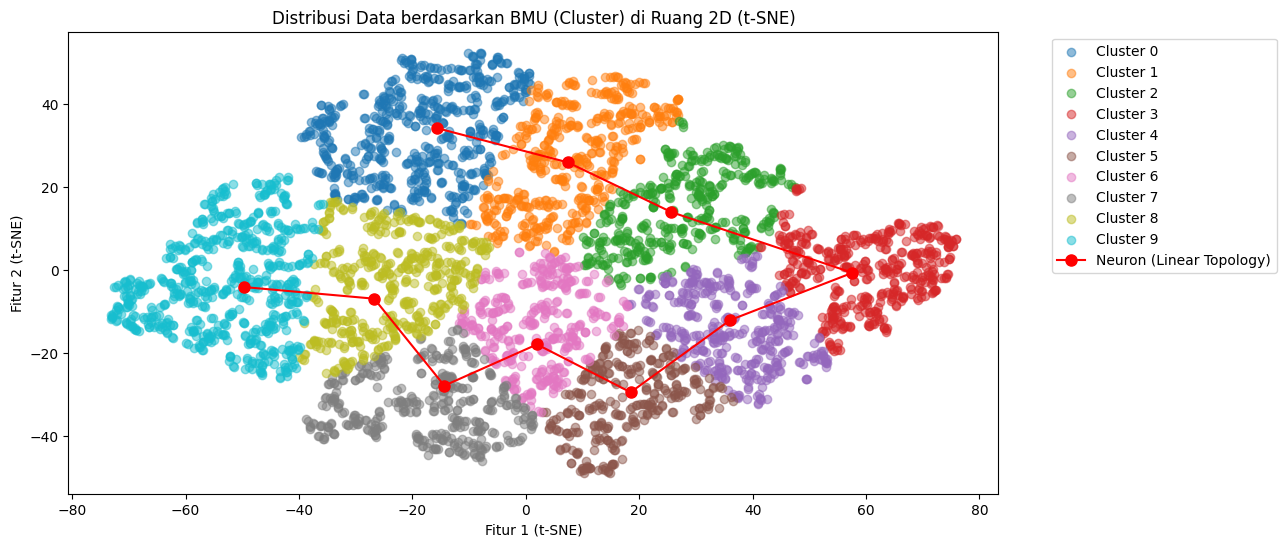

In [12]:

# Hitung BMU untuk setiap titik data dalam X_tsne
bmu_indices = np.array([som_tsne.hitung_bmu(x) for x in X_tsne])

# Buat scatter plot dengan warna berbeda untuk setiap BMU
plt.figure(figsize=(12, 6))

# Loop untuk setiap BMU unik
unique_bmu_indices = np.unique(bmu_indices)
colors = plt.cm.get_cmap("tab10", len(unique_bmu_indices))  # Menggunakan colormap 'tab10' untuk warna yang berbeda

for i, bmu in enumerate(unique_bmu_indices):
    # Filter data yang termasuk dalam BMU saat ini
    cluster_data = X_tsne[bmu_indices == bmu]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {bmu}', color=colors(i), alpha=0.5)

# Plot neuron dalam topologi linier sebagai titik merah
plt.plot(weights_tsne[:, 0], weights_tsne[:, 1], 'r-o', label="Neuron (Linear Topology)", markersize=8)

plt.title("Distribusi Data berdasarkan BMU (Cluster) di Ruang 2D (t-SNE)")
plt.xlabel("Fitur 1 (t-SNE)")
plt.ylabel("Fitur 2 (t-SNE)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [24]:
from sklearn.cluster import KMeans

num_clusters = 3  # Tentukan jumlah cluster
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(weights_tsne)
print("Cluster Labels:", kmeans.labels_)


Cluster Labels: [0 2 2 0 0 1 1 1 1 0]


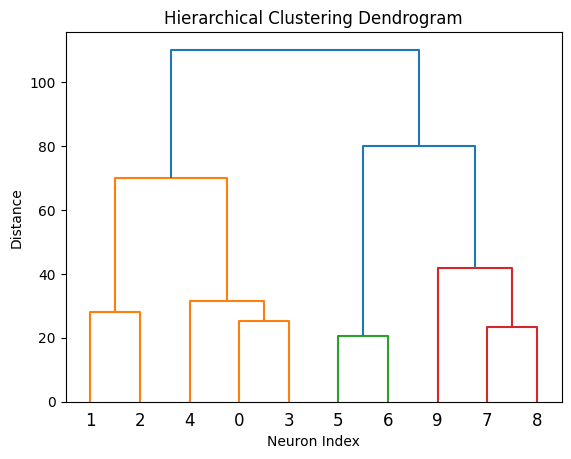

In [25]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(weights_tsne, method='ward')
dendrogram(Z)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Neuron Index")
plt.ylabel("Distance")
plt.show()


In [26]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=5)
labels = dbscan.fit_predict(weights_tsne)
print("DBSCAN Cluster Labels:", labels)


DBSCAN Cluster Labels: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


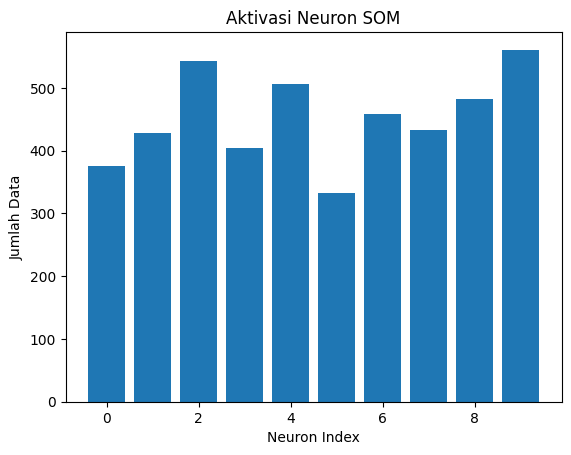

In [27]:
activations = np.zeros(m)
for x in X_tsne:
    activations[som_tsne.hitung_bmu(x)] += 1

plt.bar(range(m), activations)
plt.title("Aktivasi Neuron SOM")
plt.xlabel("Neuron Index")
plt.ylabel("Jumlah Data")
plt.show()


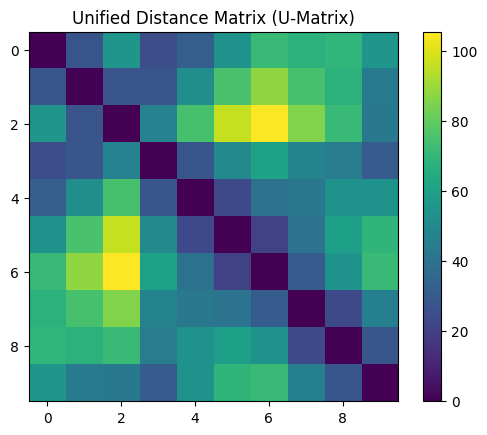

In [29]:
from scipy.spatial.distance import cdist

u_matrix = cdist(weights_tsne, weights_tsne)
plt.imshow(u_matrix, cmap='viridis')
plt.title("Unified Distance Matrix (U-Matrix)")
plt.colorbar()
plt.show()


###Evaluasi 1

In [12]:
qe = som_tsne.quantization_error(X_tsne)
te = som_tsne.topographic_error(X_tsne)

print("Quantization Error (QE):", qe)
print("Topographic Error (TE):", te)

Quantization Error (QE): 12.043366807388232
Topographic Error (TE): 0.1865605658709107


In [22]:
silhouette_avg = silhouette_score(X_tsne, y_train.values)  # Gunakan y_train untuk mencocokkan data pada X_pca
print("Silhouette Score:", silhouette_avg)

Silhouette Score: -0.06814402


In [23]:
map_size = (6, 1)  # 6 neurons in 1 row (linear SOM)

# Ambil bobot dari SOM hasil PCA yang sudah dilatih
weights_tsne = som_tsne.w  # weights_tsne seharusnya berbentuk (6, 1)

# Hitung beberapa metrik menggunakan somperf
print('Topographic Product ==', topographic_product(rectangular_topology_dist(map_size), weights_tsne))
print('Neighborhood Preservation =', neighborhood_preservation(1, weights_tsne, X_tsne))
print('Trustworthiness =', trustworthiness(1, weights_tsne, X_tsne))

Topographic Product == -0.05140133547851892
Neighborhood Preservation = 0.36137034738508
Trustworthiness = 0.9314594551060392


###Tuning

In [24]:
# import optuna
# import numpy as np
# from sklearn.metrics import silhouette_score

# # Pastikan class SOMlinier sudah didefinisikan sebelumnya dengan metode quantization_error() dan topographic_error()

# # Fungsi objektif untuk optimasi Optuna
# def objective(trial):
#     # Tuning parameter
#     m = trial.suggest_int('m', 5, 20)           # Jumlah neuron
#     R = trial.suggest_int('R', 1, 5)            # Radius
#     alpha0 = trial.suggest_float('alpha0', 0.01, 0.5)  # Learning rate
#     tau = trial.suggest_int('tau', 100, 1000)   # Konstanta peluruhan
#     n_iterations = trial.suggest_int('n_iterations', 500, 2000)  # Iterasi pelatihan
    
#     # Inisialisasi dan latih SOM dengan parameter yang dipilih
#     som = SOMlinier(m=m, fitur=X_train_np.shape[1], R=R, alpha=alpha0, tau=tau)
#     som.train(X_train_np, n_iterations)

#     # Hitung QE, TE, dan Silhouette Score
#     qe = som.quantization_error(X_train_np)
#     te = som.topographic_error(X_train_np)

#     # Hitung BMU untuk setiap data dan hitung Silhouette Score
#     bmu_indices = np.array([som.hitung_bmu(x) for x in X_train_np])
#     silhouette = silhouette_score(X_train_np, bmu_indices)
    
#     # Kombinasikan ketiga metrik dengan bobot tertentu
#     # Di sini, kita meminimalkan QE dan TE, tetapi memaksimalkan Silhouette Score
#     # Jadi kita gunakan negatif Silhouette Score (karena Optuna meminimalkan nilai)
#     combined_score = (0.4 * qe) + (0.4 * te) - (0.2 * silhouette)

#     return combined_score

# # Buat study untuk optimasi
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=30)

# # Cetak hasil terbaik
# print("Best parameters for SOM:", study.best_params)
# print("Best combined score:", study.best_value)
